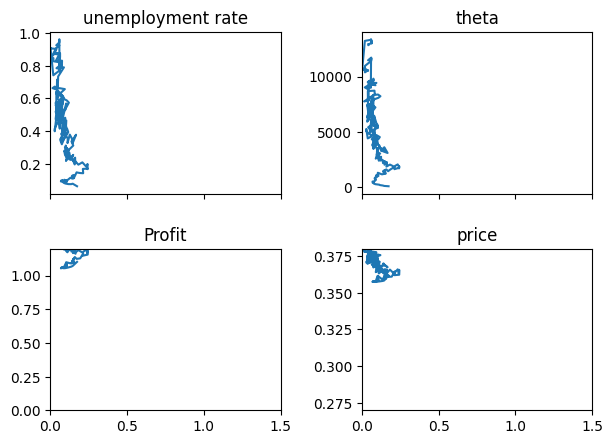

In [1]:
import random
import math
import sympy as sp
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)

job_finding_rate, job_separation_rate = 0.2, 0.2

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.01, 0.1, 0.9

# Initialize population
# not0_young_coh means persons with age from 1 to 14 inclusive
# young_coh means persons with age from 0 to 14 inclusive
newborn_coh, senior_coh, not0_young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed

    def update_age(self):
        self.age += 1

    def is_newborn(self):
        return self.age == 0

    def is_young(self):
        return self.age < 15

    def is_workforce(self):
        return 14 < self.age < retirement_age

    def is_senior(self):
        return self.age >= retirement_age

    def is_unemployed(self):
        return not self.employed

    def is_employed(self):
        return self.employed

# initialize population-related variables

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(1, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else not0_young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_coh = list(itertools.chain(newborn_coh, not0_young_coh))
pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))

cohorts = [[len(young_coh)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)

        if hire_or_fire_decision:  # Hiring decision
            self.job_vacancy += num_new_vacancies

            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), self.job_vacancy)
            #self.job_vacancy -= num_hired
            
            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            #self.job_vacancy -= num_fired
            return 0, num_fired, self.job_vacancy


    def update_prices(self, total_demand):

        supply = sum(firm.hire_or_fire(labor_market.calculate_unemployed(), \
                                                  labor_market.calculate_employed())[0] for firm in firms)
        self.price = self.vacancy_cost + math.sqrt(total_demand) / len(firms) - supply / 2500
                
        prof = max((self.price - self.vacancy_cost) * math.sqrt(total_demand),0)
        return self.price, prof
        
# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

def tt_demand(N, U, A, p_bar):
    B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
    S = N-U
    niu = min(1, S/B)

    return (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
    (N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
    U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/p_bar

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A

    def calculate_profit(self):
        p_bar0 = sum(firm.price for firm in self.firms)/len(firms)
        p_bar = sum(firm.update_prices(tt_demand(self.N, self.U, self.A, p_bar0))[0] for firm in self.firms)/len(self.firms)

        tot_demand = tt_demand(self.N, self.U, self.A, p_bar)
        tot_profit = sum(firm.update_prices(tot_demand)[1] for firm in self.firms)

        return tot_demand, tot_profit

class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

    def new_workstatus(self):
        new_emp, new_unemp, tot_job = 0, 0, 0
        for firm in self.firms:
            hired, fired, job = firm.hire_or_fire(labor_market.calculate_unemployed(), \
                                                  labor_market.calculate_employed())
            new_emp += hired
            new_unemp += fired
            tot_job += job
        return new_emp, new_unemp, tot_job

old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
random.seed(3)
num_firms = 10
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]

# Initialize the LaborMarket with firms and initial_workforce
labor_market = LaborMarket(firms)  # Pass initial_workforce here
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
initial_vacancy = labor_market.new_workstatus()[2]
theta = [initial_vacancy / labor_market.calculate_unemployed()]
initial_average_price = sum(firm.price for firm in firms) / len(firms)
prices_in_goods_market = [initial_average_price]

N, U, A = len(workforce_coh), len(unemp_coh), len(senior_coh)
B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
S = N-U
niu = min(1, S/B)

initial_total_demand = (A*(1+psi_a)/B*(1-2*psi_a/(1+psi_a)*niu)*y_a +\
(N-U)*(1+psi_e)/B*(1-2*psi_e/(1+psi_e)*niu)*wage +\
U*(1+psi_u)/B*(1-2*psi_u/(1+psi_u)*niu)*y_u)/initial_average_price

goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
tot_dem = [goods_market.calculate_profit()[0]]
job_vacancies = [initial_vacancy]

firm_profits = [goods_market.calculate_profit()[1]]

simulation_years = 300
random.seed(3)

for year in range(1, simulation_years):
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person
    
    for person in pop:
        person.update_age()
        
    for person in young_coh:
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)
# unit test
# manual test
# assert 
    for person in workforce_coh:
        if person.is_workforce():
            updated_workforce_coh.append(person)
            
            if person.is_unemployed():             
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)

    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)

    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(updated_senior_coh) * death_rate)
    random.shuffle(updated_senior_coh)
    removed_senior_coh = updated_senior_coh[:death]
    senior_coh = updated_senior_coh[death:]

    # Update the newborn
    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_young_coh.append(person)
        updated_newborn_coh.append(person)
    
    # Update the number of unemployed and employed based on new hire and fire
    for firm in firms:
        a = firm.hire_or_fire(labor_market.calculate_unemployed(), \
                                                  labor_market.calculate_employed())
    b = [sum(a[i] for firm in firms) for i in range(3)]
    
    change_of_workstatus = b[0] - b[1]  
    
   
    if change_of_workstatus >= 0:
        # measure of unemployed U1 = U0 - change_of_workstatus
        random.shuffle(updated_unemp_coh)
        removed_unemp_coh = updated_unemp_coh[:change_of_workstatus]
        updated_unemp_coh = updated_unemp_coh[change_of_workstatus:]
        
         # measure of employed E1 = E0 + change_of_workstatus
        for _ in range(change_of_workstatus):
            person = Person(age=random.randint(15, 64), employed=True)
            updated_emp_coh.append(person)
    else:
            random.shuffle(updated_emp_coh)
            removed_emp_coh = updated_emp_coh[:abs(change_of_workstatus)]
            updated_emp_coh = updated_emp_coh[abs(change_of_workstatus):]
            
    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    #senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = list(itertools.chain(updated_unemp_coh, updated_emp_coh))
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh

    pop = list(itertools.chain(young_coh, workforce_coh, senior_coh))
    #print('workforce proportion:', len(workforce_coh)/len(pop))
    #print('aged dependency ratio:', len(senior_coh)/len(workforce_coh))

    N, U, A = len(workforce_coh), len(unemp_coh), len(senior_coh)
    # Goods market dynamics
    goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
    total_demand_this_year = goods_market.calculate_profit()[0]

    #print('total_demand:', total_demand_this_year)
    tot_dem.append(total_demand_this_year)
        
    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate firm-related variables
    num_job_vacancies = b[2]
    job_vacancies.append(num_job_vacancies)
    
    tot_price = 0
    for firm in firms:
        tot_price += firm.update_prices(total_demand_this_year)[0]

    total_firm_profits = goods_market.calculate_profit()[1]
    
    supply_this_year = labor_market.new_workstatus()[0]
    
    # Calculate new employment and unemployment rates for this year
    unemployment_rate_this_year = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    unemployment_rates.append(unemployment_rate_this_year)
    
    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)
    firm_profits.append(total_firm_profits)

    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)

    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    total_prices_in_goods_market = sum(firm.update_prices(total_demand_this_year)[0] for firm in firms) / len(firms)
    prices_in_goods_market.append(total_prices_in_goods_market)
#print(tot_dem)
# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
axs[0, 0].plot(old_aged_dependency_ratios[1:], unemployment_rates[1:], label="Unemployment Rate")
axs[0, 0].set_title('unemployment rate')
axs[0, 1].plot(old_aged_dependency_ratios[1:], theta[1:], label="Labor Market Tightness")
axs[0, 1].set_title('theta')
axs[1, 0].plot(old_aged_dependency_ratios[1:], firm_profits[1:], label="Firm Profits")
axs[1, 0].set_title('Profit')
axs[1, 0].set_ylim(0, 1.2)

axs[1, 1].plot(old_aged_dependency_ratios[1:], prices_in_goods_market[1:], label="Prices in Goods Market")
axs[1, 1].set_title('price')
axs[1, 1].set_ylim(0.27, 0.38)

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
#plt.savefig('C:/Users/enmao/OneDrive - Carleton University/mas thesis/my_plot3.png')
plt.show()


In [27]:
job_vacancies


[64,
 1410,
 3380,
 5100,
 6970,
 8900,
 10830,
 12690,
 14630,
 16800,
 18700,
 20640,
 22280,
 24080,
 26000,
 27650,
 29690,
 31580,
 33260,
 35170,
 37000,
 38880,
 40990,
 42810,
 44620,
 46400,
 48430,
 50280,
 52100,
 53960,
 55810,
 57600,
 59380,
 61230,
 63030,
 64880,
 66710,
 68580,
 70510,
 72410,
 74330,
 76050,
 77840,
 79620,
 81400,
 83120,
 85100,
 87000,
 88930,
 90880,
 92770,
 94620,
 96580,
 98430,
 100440,
 102250,
 104110,
 106080,
 108120,
 109790,
 111560,
 113560,
 115270,
 117070,
 119150,
 121070,
 122990,
 124840,
 126570,
 128510,
 130410,
 132220,
 134300,
 136200,
 138130,
 140070,
 141990,
 143920,
 145870,
 147630,
 149550,
 151450,
 153480,
 155360,
 157140,
 159190,
 161100,
 162880,
 164810,
 166710,
 168470,
 170500,
 172450,
 174360,
 176150,
 178060,
 179930,
 181720,
 183670,
 185440,
 187480,
 189470,
 191390,
 193110,
 194770,
 196570,
 198540,
 200420,
 202230,
 203960,
 205830,
 207710,
 209560,
 211290,
 213240,
 215260,
 217260,
 219040,


In [20]:
for firm in firms:
    a = firm.hire_or_fire(labor_market.calculate_unemployed(), \
                                                  labor_market.calculate_employed())
b = [sum(a[i] for firm in firms) for i in range(3)]
print(b)
sum(a[2] for firm in firms)

(0, 0, 160)
(0, 0, 163)
(0, 0, 135)
(0, 0, 149)
(0, 0, 146)
(0, 0, 149)
(0, 0, 147)
(0, 0, 153)
(0, 0, 143)
(0, 0, 159)
[0, 0, 1590]


1590

1530